In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import os
import pandas as pd
from dataset import CustomDataset
from model import PretrainedResNet50
from utils import preprocess

In [3]:
base_dir = "/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/Flowers/"
file_path = f"{base_dir}jpg/files.txt"
save_path = f"{base_dir}dataset.csv"


preprocess(file_path, save_path)

In [6]:
# Modify this path according to the location of your CSV file
csv_file_path = save_path

# Define the ImageNet mean and standard deviation values
# Replace these values with the actual ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Create the transform with ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a common size (e.g., 224x224)
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),  # ImageNet normalization
])

# Create the transform with ImageNet normalization
tt = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a common size (e.g., 224x224)
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    # transforms.Normalize (mean=imagenet_mean, std=imagenet_std),  # ImageNet normalization
])
num_classes = 10  # Replace 10 with the number of classes in your dataset

# Create the custom dataset and data loader
dataset = CustomDataset(csv_file=csv_file_path, transform=tt)


# split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create train, validation, and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Iterate over the data loader to get batches of images and one-hot encoded labels
for images, one_hot_labels in train_dataloader:
    # Perform your training/validation/testing with the images and one-hot encoded labels
    print("Images shape:", images.shape)
    print("One-hot encoded labels shape:", one_hot_labels.shape)
    break  # For demonstration purposes, we'll just print the first batch

Images shape: torch.Size([32, 3, 224, 224])
One-hot encoded labels shape: torch.Size([32, 17])


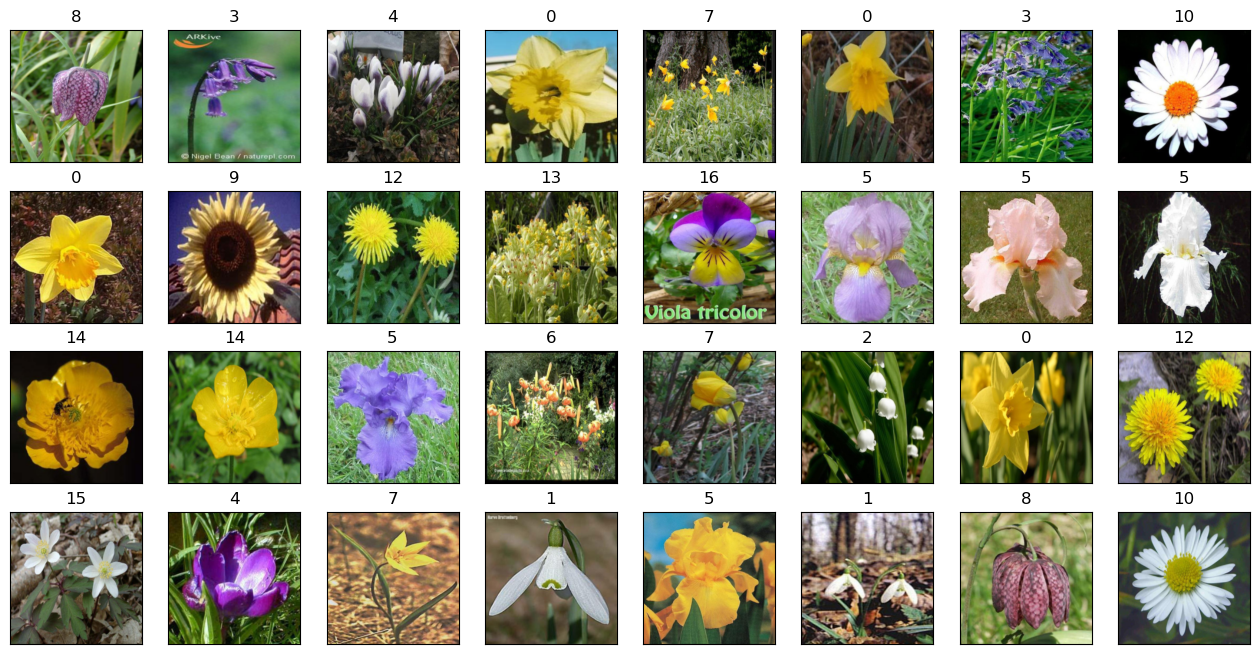

In [7]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 8))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    # convert the one-hot encoded label to an integer
    ax.set_title(np.argmax(one_hot_labels[i]).numpy().item())
# plt.savefig('Figures/plot.png')
plt.show()


### Making predictions

In [8]:
# load model
num_classes = dataset.num_classes  # Replace with the number of classes in your specific task
model = PretrainedResNet50(num_classes)

model_path = "Models/resnet50.pth"
model.load_state_dict(torch.load(model_path))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

16 16


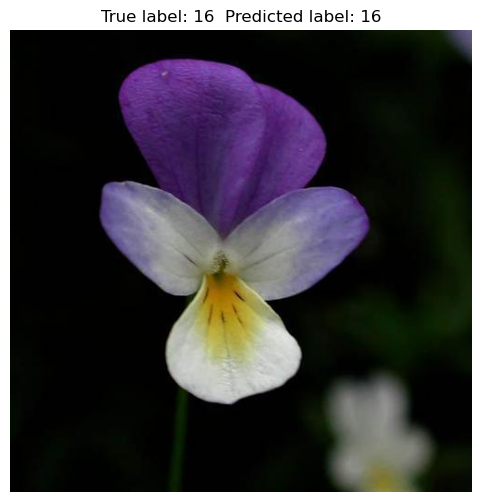

In [10]:
df = pd.read_csv(csv_file_path)
idx =  np.random.randint(0, len(df))
true_label = df.iloc[idx, 1]
image_path = df.iloc[idx, 0]
image = Image.open(image_path)
# transform the image
t_image = transform(image)
# add batch dimension
t_image = t_image.unsqueeze(0)

with torch.inference_mode():
    pred_label = model(t_image)
    pred_label = pred_label.argmax(dim=1).numpy().item()
    print(pred_label, true_label)
# pred_label = predict(model, image, device)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title(f"True label: {true_label}  Predicted label: {pred_label}")
plt.axis("off")
plt.show()

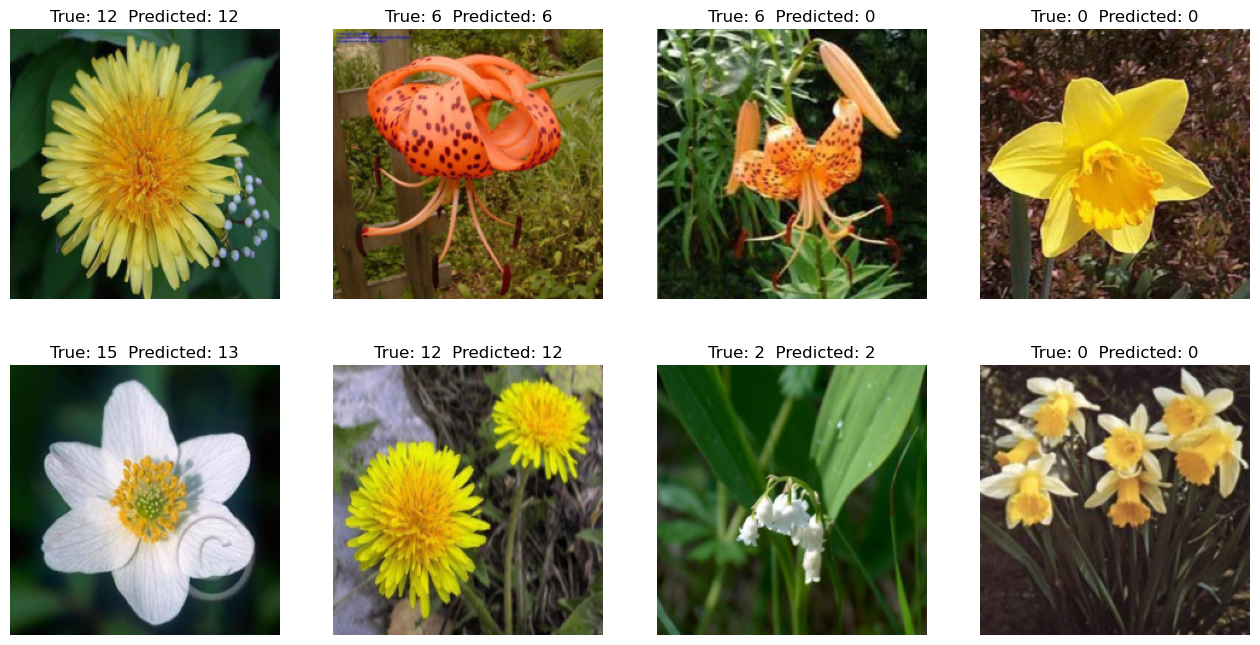

In [17]:
# make prediction for 8 images and plot them
df = pd.read_csv(csv_file_path)
fig = plt.figure(figsize=(16, 8))
for i in range(8):
    idx =  np.random.randint(0, len(df))
    true_label = df.iloc[idx, 1]
    image_path = df.iloc[idx, 0]
    image = Image.open(image_path)
    # transform the image
    t_image = transform(image)
    # add batch dimension
    t_image = t_image.unsqueeze(0)
    image = tt(image)
    with torch.inference_mode():
        pred_label = model(t_image)
        pred_label = pred_label.argmax(dim=1).numpy().item()
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    plt.imshow(image.squeeze(0).permute(1, 2, 0))
    ax.set_title(f"True: {true_label}  Predicted: {pred_label}")
    ax.axis("off")
    plt.savefig('Figures/prediction_plot_2.png')
plt.show()

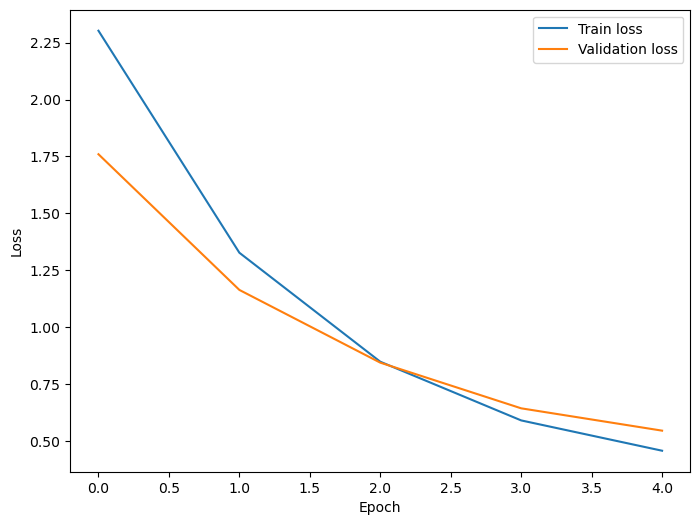

In [18]:
# plot train and validation loss curves
df = pd.read_csv("Results/history_resnet50.csv")
plt.figure(figsize=(8, 6))
plt.plot(df["epoch"], df["train_loss"], label="Train loss")
plt.plot(df["epoch"], df["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('Figures/loss_plot.png')

In [21]:
# get max train, validation
df = pd.read_csv("Results/history_resnet50.csv")
max_train_acc = df["train_acc"].max()
max_val_acc = df["val_acc"].max()
max_train_loss = df["train_loss"].min()
max_val_loss = df["val_loss"].max()
print(f"Max train accuracy: {max_train_acc:.2f}")
print(f"Max validation accuracy: {max_val_acc:.2f}")
df 

Max train accuracy: 0.98
Max validation accuracy: 0.98


,epoch,train_loss,train_acc,val_loss,val_acc
0,0,2.302374,0.482537,1.759523,0.911765
1,1,1.326582,0.901654,1.163146,0.941176
2,2,0.847570,0.948529,0.843462,0.963235
3,3,0.589563,0.967831,0.642720,0.963235
4,4,0.456364,0.978860,0.544581,0.977941


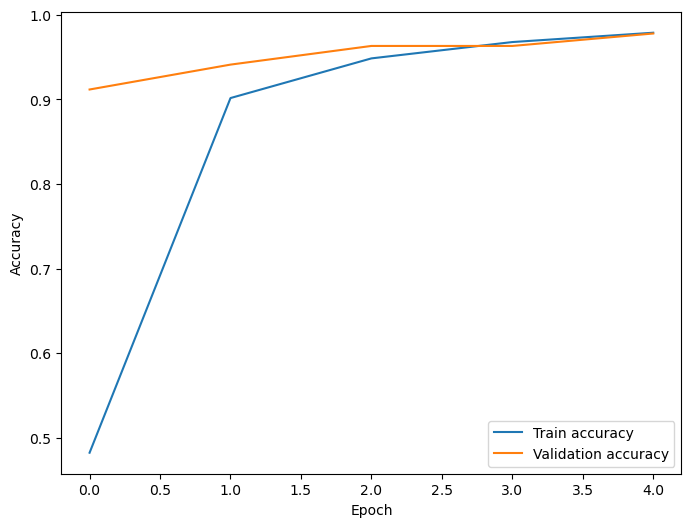

In [19]:
# plot train and validation accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(df["epoch"], df["train_acc"], label="Train accuracy")
plt.plot(df["epoch"], df["val_acc"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('Figures/accuracy_plot.png')
plt.show()